In [1]:
import numpy as np
# To make plot backgrounds white
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"
import matplotlib.pyplot as plt
import pandas as pd
import os 
import sys
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/pyOPALTools')
from opal.parser.H5Parser import H5Parser
from decimal import Decimal
from scipy.signal import find_peaks
sys.path.append('/home/arnau/documents/ETHZ/Semester_Project_Master_Thesis/plotMithraPy')
import plotMiFuncs as pmf

########################
for_report = False
prefixes = [
    'tests/test_condition=pencil_opal_noWiggler/',
]

prefixes.reverse()
generic_fn = 'und'
fs = 14
########################

if not for_report:
    from datetime import date
    today = date.today()
#     footnote = 'A.Albà, ' + str(today) + '\ndir: /' + (os.path.split(os.getcwd()))[1]
    footnote = 'A.Albà, ' + str(today)
    print(footnote)
    generic_title = 'Linacs with intial modulation'
else:
    generic_title = " "
    footnote = " "
    

A.Albà, 2020-01-21


# Functions

In [2]:
def cutoff(x,y,cut = []):
    # Sort according to x
    idx   = np.argsort(x)
    x = np.array( x )[idx]
    y = np.array( y )[idx]
    if len(cut) != 2:
        return [ x, y ]
    # Trim data
    i = 0
    while( x[i] < cut[0] ):
        i += 1
    j = len(x) - 1   
    while( x[j] > cut[1] ):
        j -= 1    
    return [ x[ i : j ], y[ i : j ] ]


def get_ps_xy( fn, step, qx, qy, boolprint = False ):    
    ''' Get data to plot from file fn and given step. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    h5p = H5Parser()
    h5p.parse( fn, boolprint )
    x = []
    for qi in qx:
        x.append( h5p.getStepDataset( dsetName = qi, step = step) )
    y  = []
    for qi in qy:
        if qi == 'E':
            # Get E
            E = []
            px = h5p.getStepDataset( dsetName = 'px', step = step)
            py = h5p.getStepDataset( dsetName = 'py', step = step)
            pz = h5p.getStepDataset( dsetName = 'pz', step = step)
            for i, pxi in enumerate(px):
                p2 = px[i]**2 + py[i]**2 + pz[i]**2  
                E.append( np.sqrt( 1 + p2 )*.511 )
            y.append( E )
        else:
            y.append( h5p.getStepDataset( dsetName = qi, step = step) )
    
    spos = h5p.getStepAttribute('SPOS', step = step)
    nSteps = h5p.getNSteps()
    if ( boolprint ):
        print(h5p.getStepDatasets(step = step))
        print('spos = ',spos)
    if len(x) == 1:
        x = x[0]
    if len(y) == 1:
        y = y[0]

    
    return [ x, y, spos[0], nSteps ]


def get_screen_xy( fn_prefix, screen_name, qx, qy, show = False ):    
    ''' Get data to plot from file fn and given screen. qx and qy are arrays of strings with data to plot
    eg ['z'], ['x', 'E'] '''
    fn = fn_prefix + screen_name
    h5p = H5Parser()
    step = 0
    h5p.parse( fn, False )
    if show:
        print(h5p)
        
    x = h5p.getStepDataset( dsetName = qx, step = step)
    if qy == 'E':
        # Get E
        E = []
        px = h5p.getStepDataset( dsetName = 'px', step = step)
        py = h5p.getStepDataset( dsetName = 'py', step = step)
        pz = h5p.getStepDataset( dsetName = 'pz', step = step)
        for i, pxi in enumerate(px):
            p2 = px[i]**2 + py[i]**2 + pz[i]**2  
            E.append( np.sqrt( 1 + p2 )*.511 )
        y = E
    else:
        y = h5p.getStepDataset( dsetName = qy, step = step)
            
    spos = h5p.getStepAttribute('SPOS', step = step)
    if show:
        print('spos = ',spos)

    
    return [ x, y, spos[0] ]


def FT( x, y, cut = [], nbins = 100, boolplot = False, prominence = 0.0 ):
    [x, y] = cutoff( x, y, cut )
    # Set y data to average 0
    y -= np.average(y)
    # Get data organised in bins
    x_bins = np.linspace( np.min(x), np.max(x), nbins )
    digitized = np.digitize( x, x_bins ) - 1 
    y = np.array(y)
    y_means = [ y[digitized == i].mean() for i in range(nbins) ]
    # Plot
    if boolplot:
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(15, 5)
        ax[0].scatter( x_bins, y_means, marker = '.', color = 'k' )
        ax[0].grid()
        ax[0].tick_params( axis = 'both', labelsize = fs)
        if len(cut) != 0:
            ax[0].set_xlim( left = cut[0], right = cut[1]  )
    # Fourier transform        
    dist = np.max(x) - np.min(x)
    amp = np.fft.fft(y_means)[:nbins//2] / nbins
    freq = np.arange( nbins//2 ) / dist
    # Find peak frequencies
    peaks, _ = find_peaks( np.abs(amp), prominence = prominence )
    amp_peaks = np.abs(amp)[peaks]
    peaks = peaks / dist
    if boolplot:
        for peak in peaks:
            ax[1].axvline( peak, color = 'r' )
        ax[1].plot( freq, np.abs(amp) )
        ax[1].grid()
        ax[1].tick_params( axis = 'both', labelsize = fs)
        ax[1].set_xlabel('freq [$m^-1$]')
        print('peaks at ', peaks)
    
    return [ freq, amp, peaks, amp_peaks ]

# Plot stats

In [30]:
fn = prefixes[-1] + generic_fn + '.stat'
print(fn)
text = open( fn, 'r' )
names = []
units = []
for line in text:
    if 'name' in line:
        ind1 = line.find('=')
        ind2 = line.find(',')
        name = line[ind1+1:ind2]
    if 'units' in line:
        ind1 = line.find('=')
        ind2 = line.find(',')
        unit = line[ind1+1:ind2]
        if unit == '1':
            unit = ' '
        names.append( name )
        units.append( unit )
for i, n in enumerate(names):        
    print( i, n, ' [', units[i], ']' )
stat = pd.read_csv( filepath_or_buffer = fn,
                   skiprows = 279, sep = '\s+', names = names)

tests/test_condition=pencil_opal_noWiggler/und.stat
0 t  [ ns ]
1 s  [ m ]
2 numParticles  [   ]
3 charge  [   ]
4 energy  [ MeV ]
5 rms_x  [ m ]
6 rms_y  [ m ]
7 rms_s  [ m ]
8 rms_px  [   ]
9 rms_py  [   ]
10 rms_ps  [   ]
11 emit_x  [ m ]
12 emit_y  [ m ]
13 emit_s  [ m ]
14 mean_x  [ m ]
15 mean_y  [ m ]
16 mean_s  [ m ]
17 ref_x  [ m ]
18 ref_y  [ m ]
19 ref_z  [ m ]
20 ref_px  [   ]
21 ref_py  [   ]
22 ref_pz  [   ]
23 max_x  [ m ]
24 max_y  [ m ]
25 max_s  [ m ]
26 xpx  [   ]
27 ypy  [   ]
28 zpz  [   ]
29 Dx  [ m ]
30 DDx  [   ]
31 Dy  [ m ]
32 DDy  [   ]
33 Bx_ref  [ T ]
34 By_ref  [ T ]
35 Bz_ref  [ T ]
36 Ex_ref  [ MV/m ]
37 Ey_ref  [ MV/m ]
38 Ez_ref  [ MV/m ]
39 dE  [ MeV ]
40 dt  [ ns ]
41 partsOutside  [   ]


In [10]:
fn = str( prefix + 'data/' + generic_fn + '_DIST.dat')
dist = pd.read_csv( filepath_or_buffer = fn, skiprows = 1, sep = '\s+',
                   names = [ 'x', 'px', 'y', 'py', 't', 'pz', 'nBins'])

t = np.array(dist['t'])*1e12
t -= np.average(t)
fig, ax = plt.subplots()
ax.hist(t, bins = 100, histtype = 'step', linewidth = 2)
ax.set_xlabel('t [ps]', fontsize = fs)
ax.set_ylabel('density [arb]', fontsize = fs)
ax.tick_params( axis = 'both', labelsize = fs)
ax.grid()
ax.set_title('Initial bunch distribution', fontsize = fs)

plt.text( .75, -.25, footnote, transform=ax.transAxes )
#     plt.title(generic_title, fontsize = fs)
plt.savefig('plots/initialDist.eps', bbox_inches='tight')
    
plt.show()


FileNotFoundError: [Errno 2] File b'tests/modulation_MT64_N1e5_1nC/data/fullBeamline_DIST.dat' does not exist: b'tests/modulation_MT64_N1e5_1nC/data/fullBeamline_DIST.dat'

# Fourier Analysis

tests/modulation_MT16_N5e4/singleRun_optLinac_40nC.h5
peaks at  [1.00007986e+11 1.70013576e+12 2.10016770e+12 2.60020763e+12
 2.90023158e+12 3.10024756e+12 3.70029547e+12 3.90031144e+12
 4.10032741e+12 4.40035137e+12 4.70037533e+12 5.00039928e+12
 5.40043123e+12 5.70045518e+12 5.90047115e+12 6.20049511e+12
 6.60052705e+12 6.90055101e+12 7.20057497e+12 7.60060691e+12
 7.90063087e+12 8.10064684e+12 8.40067080e+12 8.70069475e+12]
tests/modulation_MT32_N5e4/singleRun_optLinac_40nC.h5
peaks at  [1.00014268e+11 5.00071339e+11 8.00114143e+11 1.70024255e+12
 1.90027109e+12 2.10029962e+12 2.90041377e+12 3.10044230e+12
 3.80054218e+12 4.10058498e+12 4.30061352e+12 4.70067059e+12
 5.00071339e+12 5.50078473e+12 5.70081327e+12 6.00085607e+12
 6.20088461e+12 6.40091314e+12 6.60094168e+12 7.00099875e+12
 7.30104155e+12 7.60108436e+12 8.00114143e+12 8.20116996e+12
 8.50121277e+12 8.70124130e+12]
tests/modulation_MT48_N5e4/singleRun_optLinac_40nC.h5
peaks at  [1.00011752e+11 5.00058761e+11 7.00082266e+

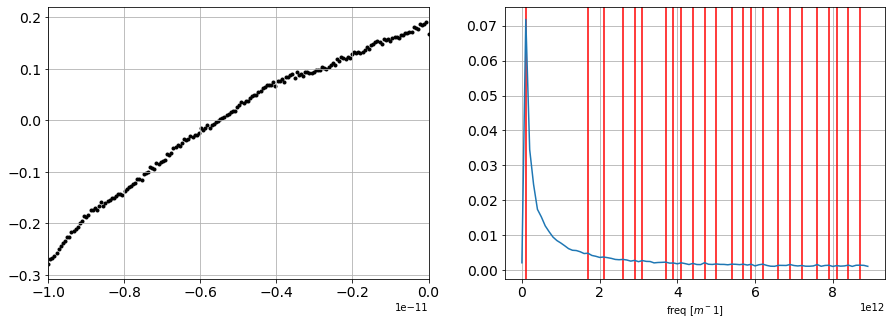

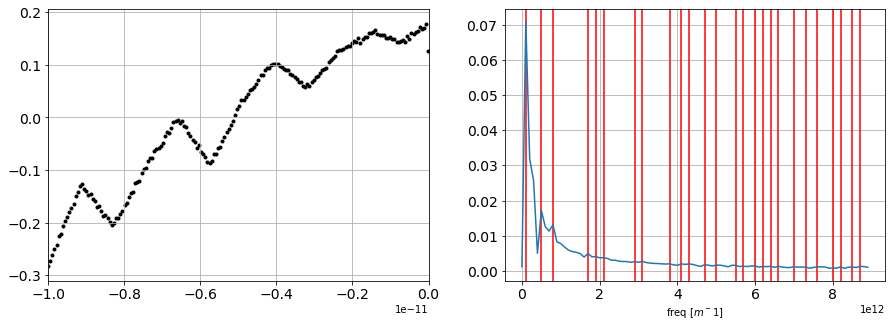

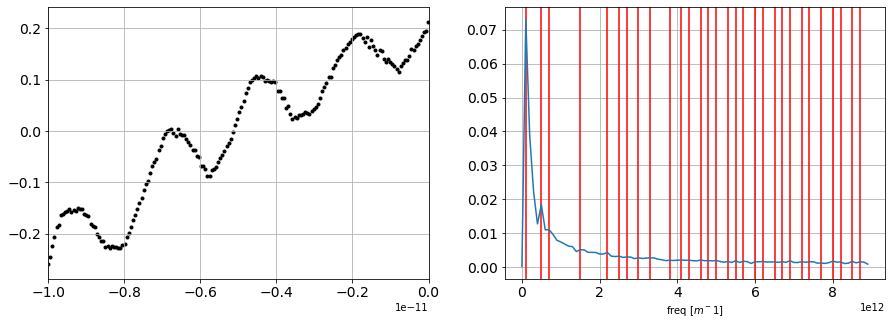

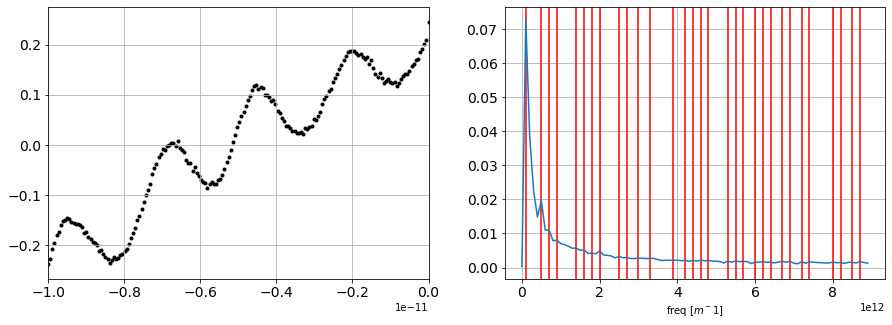

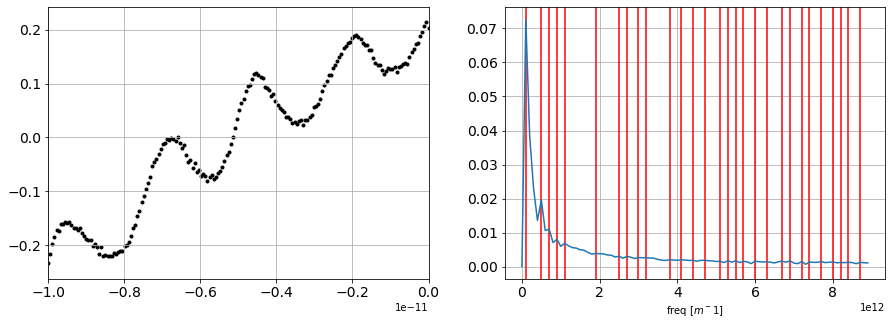

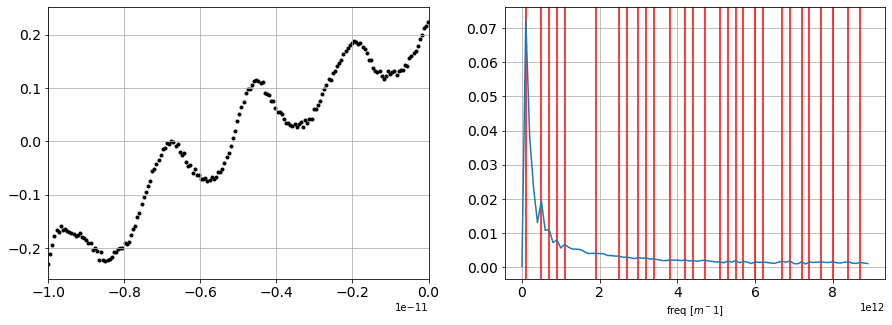

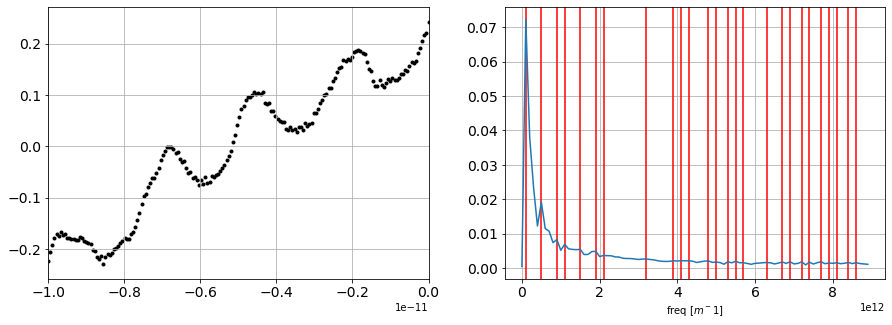

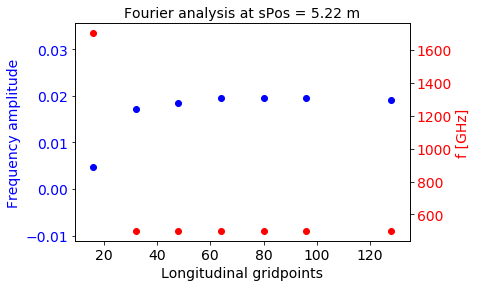

In [41]:
# Make Fourier transform
step = 2
qx = 'z'
qy = 'E'
freqs1 = []
freqs2 = []
freqs3 = []
max_freq = []
MTs = [ 16, 32, 48, 64, 80, 96, 128 ]
for pref in prefixes:
    fn = pref + generic_fn + '.h5'
    print(fn)
    [ x, y, spos, nSteps ] = get_ps_xy( fn, step, qx, qy, False)

    # Do the Fourier Trans
    [freq, amp, peaks, amp_peaks] = FT( x/3e8, y, cut = [-1e-11,0], nbins = 180, boolplot = True )
    freqs1.append(amp_peaks[0])
    freqs2.append(amp_peaks[1])
    freqs3.append(amp_peaks[2])
    #    max_freq.append( peaks[np.argmax(amp_peaks)] )
    max_freq.append( peaks[1] * 1e-9 )

fig, ax = plt.subplots()
ax.scatter(MTs, freqs2, color = 'b')
ax.tick_params(axis = 'y', labelsize = fs, labelcolor = 'b')
ax.tick_params(axis = 'x', labelsize = fs)
ax.set_xlabel('Longitudinal gridpoints', fontsize = fs)
ax.set_ylabel('Frequency amplitude', fontsize = fs, color = 'b')
ax.set_title('Fourier analysis at sPos = 5.22 m' , fontsize = fs )
ax2 = ax.twinx()
ax2.scatter( MTs, max_freq, color = 'r' )
ax2.set_ylabel( 'f [GHz]', fontsize = fs, color = 'r')
ax2.tick_params(axis = 'y', labelsize = fs, labelcolor = 'r')
plt.savefig('plots/freq_comparison.eps', bbox_inches='tight')

# fig, ax = plt.subplots()
# ax.scatter(MTs, max_freq)
# ax.tick_params(axis = 'both', labelsize = fs)
# ax.set_xlabel('Longitudinal gridpoints', fontsize = fs)
# ax.set_ylabel('Main frequency [Hz]', fontsize = fs)
# ax.set_title('Fourier analysis at sPos = 5.22 m' , fontsize = fs )
# plt.savefig('plots/main_freq.eps', bbox_inches='tight')

# fn = prefix + generic_fn + '.h5'
# fig, ax = plt.subplots()
# # ax.scatter( x, y, marker = '.' )
# ax.hist2d( x, y, bins = 150, cmin = 1 )
# # ax.hist( x, bins = 100 )
# ax.grid()
# ax.set_xlabel(qx, fontsize = fs)
# ax.set_ylabel(qy, fontsize = fs)
# ax.tick_params(axis = 'both', labelsize = fs)
# ax.text( .75, -.25, footnote, transform=ax.transAxes )
# plt.title(str(generic_title + ' at ' + '%.2f' % Decimal(spos) + ' m' ), fontsize = fs)
# plt.savefig('plots/Energy_end.eps', bbox_inches='tight')
plt.show()

# Phase Space

H5OverflowError: [91m[1mError: Only 0 steps.[0m

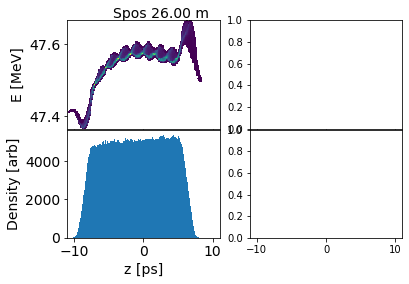

H5OverflowError: [91m[1mError: Only 0 steps.[0m

In [11]:
# Evolution of phase space and current
useSteps = [ 0, 3 ]

fn = prefixes[-1] + generic_fn + '.h5'
fig, axs = plt.subplots( 2, len(useSteps), sharex = True, gridspec_kw={'hspace': .01} )
axs = axs.reshape( -1, order = 'F' )
for i, step in enumerate(useSteps):
    [ x, y, spos, nSteps ] = get_ps_xy( fn, step, 'z', 'E', False)
 #    x *= 1e3
    ax = axs[2*i]
    ax.tick_params( axis = 'both', labelsize = fs)
    ax.text( .3, 1.02, 'Spos ' + '%.2f' % Decimal(spos) + ' m' , transform=ax.transAxes, fontsize = fs )
    ax.hist2d( x/3e8*1e12, y, bins = 150, cmin = 1)
    ax = axs[2*i+1]
    ax.set_xlim(left = -11, right = 11)
    ax.tick_params( axis = 'both', labelsize = fs)
    ax.hist( x/3e8*1e12, bins = 500)
    ax.set_xlabel('z [ps]', fontsize = fs)
    if step == 0:
        axs[2*step].set_ylabel('E [MeV]', fontsize = fs)
        ax.set_ylabel('Density [arb]', fontsize  =fs )
fig.set_size_inches(12, 8)
fig.suptitle( fn[:-len(generic_fn+'.h5')], fontsize = fs )
plt.savefig('plots/1nC_phase_space_modulation.eps', bbox_inches='tight')
    

(1000000, 2)


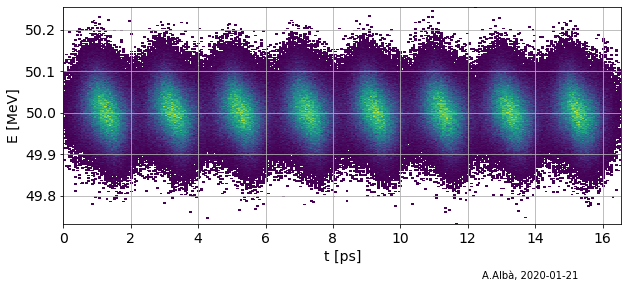

In [36]:
# Plot screens
fig, ax = plt.subplots()
for i,p in enumerate(prefixes):
    fn = p
    [x,y,spos] = get_screen_xy( fn, 'DYAG2.h5', 'time', 'E', show = False )
    # df = pd.DataFrame(np.array([x,y]).T)
    # print(df.shape)
    # df.to_csv( 'opalScreen2', sep = '\t', header = False, index = False)
    x *= 1e12
    x -= np.min(x)
    ax.hist2d( x, y, bins = 300, cmin = 1 )
#    ax.hist( x, bins = 1000)
    ax.grid()
    ax.set_ylabel('E [MeV]', fontsize = fs)
    ax.set_xlabel('t [ps]', fontsize = fs)
    ax.tick_params(axis = 'both', labelsize = fs)
    ax.text( .75, -.25, footnote, transform=ax.transAxes )
#    ax.text( .05, .75, 'bunch charge = ' + str(charge[i]), fontsize = fs, transform = ax[i].transAxes  )

fig.set_size_inches(10, 4)
# ax.set_xlabel(qx, fontsize = fs)
# fig.suptitle(str(generic_title + ',\n energy distribution after last cavity'), fontsize = fs)

#plt.savefig('plots/screens.eps', bbox_inches='tight')
plt.show()


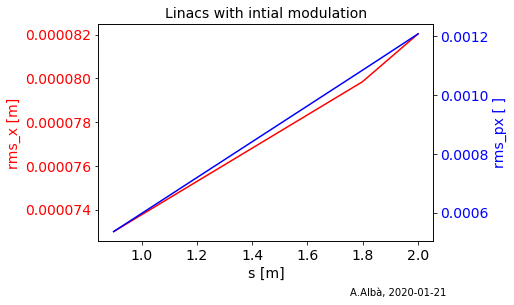

In [ ]:
################################
xax = 1
ylax = 5
yrax = 8  # -1 to plot only one quantity
colorL = 'r'
colorR = 'b'
################################
x = np.array( stat[names[xax]] )
labxax = str( names[xax] + ' [' + units[xax] + ']')

y = np.array( stat[names[ylax]] )
labyax = str( names[ylax] + ' [' + units[ylax] + ']')
if 'emit' in labyax:
    y = np.log(y)
    labyax = 'log ' + labyax

fig, ax1 = plt.subplots()
ax1.plot( x, y, color = colorL )
ax1.set_xlabel(labxax, fontsize = fs)
ax1.set_ylabel(labyax, fontsize = fs, color = colorL)
ax1.tick_params( axis = 'y', labelsize = fs, labelcolor = colorL )
ax1.tick_params( axis = 'x', labelsize = fs, labelcolor = 'k')


plt.text( .75, -.25, footnote, transform=ax1.transAxes )
plt.title(generic_title, fontsize = fs)


if yrax != -1:
    y = np.array( stat[names[yrax]] )
    labyax = str( names[yrax] + ' [' + units[yrax] + ']')
    if 'emit' in labyax:
        y = np.log(y)
        labyax = 'log ' + labyax
    ax2 = ax1.twinx()
    ax2.plot( x, y, color = colorR )
    ax2.set_ylabel(labyax, fontsize = fs, color = colorR)
    ax2.tick_params( axis = 'y', labelsize = fs, labelcolor = colorR )


#plt.savefig('plots/emit.eps', bbox_inches='tight')

plt.show()

In [12]:
numPr = len(prefixes)
charge = [ ]

fig, ax = plt.subplots( int(numPr/2), 2, sharex = True, sharey = False )
ax = ax.reshape(-1)

for i, pref in enumerate(prefixes[1:]):
    [x,y,spos] = get_screen_xy( pref, 'DYAG4.h5', 'time', 'E', show = False )
    x *= 1e12
    x -= np.min(x)
#     ax[i].hist2d( x, y, bins = 300, cmin = 1 )
    ax[i].hist( x, bins = 1000)
    ax[i].grid()
    ax[i].set_ylabel('density [arb]', fontsize = fs)
    ax[i].set_xlabel('t [ps]', fontsize = fs)
    ax[i].tick_params(axis = 'both', labelsize = fs)
    ax[i].text( .75, -.25, footnote, transform=ax[i].transAxes )
    ax[i].text( .05, .75, 'bunch charge = ' + str(charge[i]) + ' nC',
               fontsize = fs, transform = ax[i].transAxes  )
    
fig.set_size_inches(20, 8)
# ax.set_xlabel(qx, fontsize = fs)
fig.suptitle(str(generic_title + ',\n energy distribution after last cavity'), fontsize = fs)

plt.savefig('plots/Energy_end.eps', bbox_inches='tight')
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'plots/Energy_end.eps'

<Figure size 1440x576 with 0 Axes>

FileNotFoundError: [Errno 2] No such file or directory: 'plots/Energy_end.eps'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


tests/modulation_MT64_N1e5_1nC/
spos =  0.10999525890432466


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


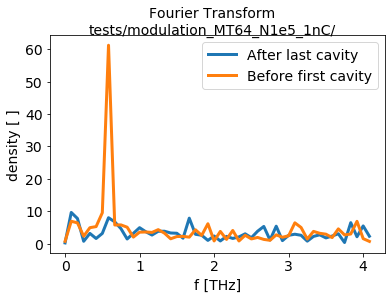

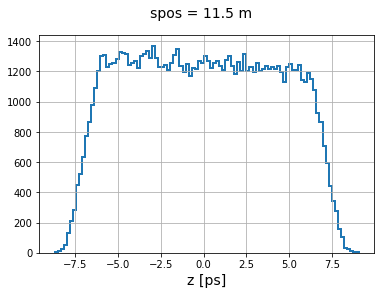

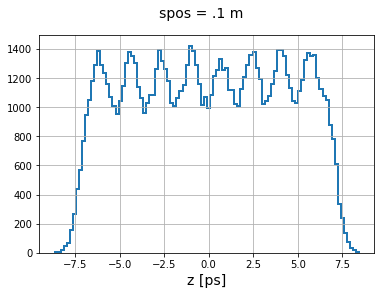

In [60]:
figFT, axFT = plt.subplots()

## After last cavity
pref = prefixes[-1]
nbins = 100
print(pref)
[x,y,spos] = get_screen_xy( pref, 'DYAG4.h5', 'time', 'x' )
x = ( x - x.mean() )*1e12
fig, ax = plt.subplots()
fig.suptitle('spos = 11.5 m', fontsize = fs)
ax.set_xlabel('z [ps]', fontsize = fs)
ax.hist(x, bins = nbins, histtype = 'step', linewidth = 2)
[x,y] = cutoff(x,y,[-6,6])
[y,x] = np.histogram(x, bins = nbins)
y -= int(np.average(y))
#ax.plot( x[:-1], y, lw = 3 )
ax.grid()
# Fourier transform        
dist = np.max(x) - np.min(x)
amp = np.fft.fft(y)[:nbins//2] / nbins
amp = np.abs(amp)
freq = np.arange( nbins//2 ) / dist
# Find peak frequencies
peaks, _ = find_peaks(amp, prominence = .2 )
amp_peaks = amp[peaks]
peaks = peaks / dist
# for p in peaks:
#     axFT.axvline(p, color = 'r')
axFT.plot(freq,amp, linewidth = 3)

# Right after the gun
fn = pref + generic_fn + '.h5'
[ x, y, spos, nSteps ] = get_ps_xy( fn, step = 0, qx = 'z', qy = 'y', boolprint = False)
print('spos = ', spos)
x = ( x - x.mean() )*1e12/3e8
fig, ax = plt.subplots()
fig.suptitle('spos = .1 m', fontsize = fs)
ax.set_xlabel('z [ps]', fontsize = fs)
ax.hist(x, bins = nbins, histtype = 'step', linewidth = 2)
[x,y] = cutoff(x,y,[-6,6])
[y,x] = np.histogram(x, bins = nbins)
y -= int(np.average(y))
#ax.plot( x[:-1], y, lw = 3 )
ax.grid()
# Fourier transform        
dist = np.max(x) - np.min(x)
amp = np.fft.fft(y)[:nbins//2] / nbins
amp = np.abs(amp)
freq = np.arange( nbins//2 ) / dist
# Find peak frequencies
peaks, _ = find_peaks(amp, prominence = .2 )
amp_peaks = amp[peaks]
peaks = peaks / dist
# for p in peaks:
#     axFT.axvline(p, color = 'r')
axFT.plot(freq,amp, linewidth = 3)
axFT.legend(['After last cavity','Before first cavity'], fontsize = fs)
axFT.set_xlabel('f [THz]', fontsize = fs)
axFT.set_ylabel('density [ ]', fontsize = fs )
axFT.tick_params(axis = 'both', labelsize = fs)
figFT.suptitle('Fourier Transform\n' + pref, fontsize = fs)
figFT.savefig('plots/den_FFT.eps', bbox_inches='tight')
plt.show()

In [2]:

np.array([1,2])

array([1, 2])